# 1. Introduction
### Advertising Campaigns
Businesses often create advertising campaigns to increase business performance. The business goal can be increasing the frequency or amount of customer purchases (*deep selling*), encouraging customers to upgrade (*up selling*), trying to sell a new product to customers (*cross selling*), or some other goal such as acquiring completely new customers.

When a customer has been targeted by an advertising campaign, we say this customer has been *treated*, while the advertisement itself is the *treatment*. Advertising campaigns can take many forms, and almost everyone is familiar with the most common forms: mailed advertisements, promotional email campaigns, or promoted online search engine results. An important point here is that deploying an advertising campaign costs money -- every letter we mail or online ad we pay for costs something, so it's important that we're targeting the right people. If we send an ad to 100,000 people for \$0.25 per ad, and none of the customers are persuaded by the ad, we just wasted \$25,000.
### Uplift Modeling
**Uplift modeling** is a machine learning technique that allows us to identify those customers most likely to be persuaded by an advertising campaign, while avoiding those customers who are immune to the campaign as well as those who would be less likely to purchase after receiving an advertisement (called "do-not-disturbs" -- they could be put-off for a number of reasons, such as being reminded of an active subscription they want to cancel, or being annoyed at receiving an ad). The framework for uplift modeling is rather straight-forward: customers are *randomly* assigned to the *treatment* or *control* group, i.e. to be targeted by the advertisement or not, which allows us to infer the causal relationship between treatment and outcome.

For this workbook, I employ the basic "Two-Model Method", which involves training two probabilistic binary classifier models on the treatment and control groups. For each sample in a holdout set, I calculate the probability of purchase (or whatever target we've selected for the given problem) if the sample is treated or not treated. The difference is the predicted *uplift* caused by the treatment.

An important, if perhaps obvious, point is that we can never know the counter-factual case for each individual in our dataset, i.e. we can never know how a customer would respond both if they were targeted and if the advertisement was withheld. Instead, we must rely on the methodology previously mentioned, which allows us to at least profile the type of customer that responds favorably to an advertising campaign. In future campaigns, we could then run the potential customer population through our modeling framework and select only those most likely to be persuaded by the campaign.

The evaluation of this modeling framework is the most critical part of the uplift modeling process, and a bit less intuitive than the modeling step itself. Below I explain each step in the evaluation process, as well as the code that makes this evaluation possible.

### CRITEO Dataset
For this project, I use the [CRITEO Uplift Prediction Dataset](http://cail.criteo.com/criteo-uplift-prediction-dataset/), which is a collection of 25M individual-level samples from an online advertising campaign. The target is visiting the advertiser's website, and includes 12 randomly projected feature variables for each sample.

My step-by-step process is a replication of the work done by the original authors of the dataset, who detail their process in [a paper](https://s3.us-east-2.amazonaws.com/criteo-uplift-dataset/large-scale-benchmark.pdf) released along with the CRITEO dataset. 

# 2. Read in the Data & Sanity Checks
Similar to the authors of the original paper, after loading the dataset (available at link in above section), I confirm two things:
1. Customers in the control group were not exposed to the advertisement. If customers who were not supposed to be shown the advertisement were in fact shown the advertisement, this compromises the random nature of the experiment and would compromise the causality assumption we're trying to infer from treatment. The authors claimed only a small rate of non-compliance, and dropped those rows from the dataset, so we should find zero rows.
2. The features are actually able to predict the target. If the feature variables provided in the dataset aren't able to predict the target (visiting the advertiser's website), there's not much point in the exercise. To confirm this, I train a simple logistic regression classifier and examine its log-loss improvement over a baseline model.

In [1]:
# typical packages
import numpy as np
import pandas as pd
import random
# classification packages
import sklearn.linear_model as lm
import sklearn.metrics as metrics
# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# define file location
file = '/Users/adouglas/Downloads/criteo-uplift.csv'

In [4]:
# since the actual dataset is over 25M lines long, and I'm doing this work on my local machine,
# I need to read in a subset of the data. Still should be performative enough to accurately model uplift

# number of rows to sample
sample_rows = 100000

# number of rows in dataset
num_lines = sum(1 for l in open(file))

# index of rows we'll be skipping, for pandas' read_csv method
skip_idx = random.sample(range(1, num_lines), num_lines - sample_rows - 1)

In [5]:
# read in the file, with randomly selected subset of rows
data = pd.read_csv(file, skiprows=skip_idx)

In [6]:
# examine the data
print(data.shape)
data.sample(3)

(100000, 16)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
38018,1.991981,3.263641,8.272483,3.735871,3.506733,10.161281,2.981721,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0,0,0
53530,1.991981,3.263641,9.010079,3.735871,3.506733,10.161281,2.981721,-0.166689,-15.258404,9.850093,-1.8609,4.157648,1,0,0,0
60852,-1.286884,3.263641,8.272483,3.735871,3.506733,10.161281,0.945163,-0.166689,1.107571,9.850093,-1.8609,4.157648,1,0,0,0


In [7]:
# what's the precentage of 'treatment'?
data['treatment'].value_counts(normalize=True)

1    0.84537
0    0.15463
Name: treatment, dtype: float64

In [8]:
# what's our baseline expectation for 'visit'?
data['visit'].value_counts(normalize=True)

0    0.95953
1    0.04047
Name: visit, dtype: float64

#### Sanity Check 1: Are Control Group Members Exposed to Treatment?

In [9]:
# should be zero positive values
data[data['treatment'] == 0]['exposure'].value_counts()

0    15463
Name: exposure, dtype: int64

#### Sanity Check 2: Can the Features Predict the Target? (Or are at least an improvement over chance model.)
- For this check, we're simply confirming an improvement over the log-loss of a baseline model, so we don't worry about train/test split, hyper-parameter tuning, algorithm selection, etc. If we didn't see an improvement, then might be appropriate to explore some of these options.
- Similar to the authors, I compare log-loss improvement when predicting the target for the whole dataset, as well as just treatment and control groups separately.

##### Log-loss improvement for predicting 'visit' on whole dataset

In [10]:
# train our model
model = lm.LogisticRegression()
model.fit(data.iloc[:,:12], data['visit']);

In [11]:
# average log-loss for our trained model
log_loss_model = metrics.log_loss(data['visit'], model.predict_proba(data.iloc[:,:12]))
log_loss_model

0.10615449409535563

In [12]:
# average log-loss when predicting 0 for all samples
log_loss_baseline = metrics.log_loss(data['visit'], [0]*len(data))
log_loss_baseline

1.397784280702036

In [13]:
# log-loss improvement over baseline model
str(round(( 1 - log_loss_model / log_loss_baseline ) * 100, 1)) + '% improvement over baseline'

'92.4% improvement over baseline'

##### Log-loss improvement for predicting 'visit' on treatment group

In [14]:
# train our model
model = lm.LogisticRegression()
model.fit(data[data['treatment'] == 1].iloc[:,:12], data[data['treatment'] == 1]['visit']);

In [15]:
# average log-loss for our trained model
log_loss_model = metrics.log_loss(data[data['treatment'] == 1]['visit'], model.predict_proba(data[data['treatment'] == 1].iloc[:,:12]))
log_loss_model

0.1117019682598608

In [16]:
# average log-loss when predicting 0 for all samples
log_loss_baseline = metrics.log_loss(data[data['treatment'] == 1]['visit'], [0]*len(data[data['treatment'] == 1]))
log_loss_baseline

1.499021382269626

In [17]:
# log-loss improvement over baseline model
str(round(( 1 - log_loss_model / log_loss_baseline ) * 100, 1)) + '% improvement over baseline'

'92.5% improvement over baseline'

##### Log-loss improvement for predicting 'visit' on control group

In [18]:
# train our model
model = lm.LogisticRegression()
model.fit(data[data['treatment'] == 0].iloc[:,:12], data[data['treatment'] == 0]['visit']);

In [19]:
# average log-loss for our trained model
log_loss_model = metrics.log_loss(data[data['treatment'] == 0]['visit'], model.predict_proba(data[data['treatment'] == 0].iloc[:,:12]))
log_loss_model

0.07427827178728018

In [20]:
# average log-loss when predicting 0 for all samples
log_loss_baseline = metrics.log_loss(data[data['treatment'] == 0]['visit'], [0]*len(data[data['treatment'] == 0]))
log_loss_baseline

0.8443159462766766

In [21]:
# log-loss improvement over baseline model
str(round(( 1 - log_loss_model / log_loss_baseline ) * 100, 1)) + '% improvement over baseline'

'91.2% improvement over baseline'

# 3. Calculate Uplift and Evaluate Using Qini
Under the Two-Model Method, Uplift is calculated by training two separate probabilistic classifiers on the treatment group and the control group. Uplift is then the difference between the probability of a positive outcome when treated versus the probability of a positive outcome when untreated.

The critical issue here is the evaluation of the model. A perfect model is assumed here to be one that assigns the highest uplift scores to those customers who have a positive outcome when treated, and conversely assigns the lowest uplift scores to those customers who have a positive outcome when untreated. In this way, we're assuming that the treatment alone is responsible for the positive outcomes among those treated, while we avoid targeting those customers who have a positive outcome when untreated.

#### Qini Coefficient
To actually evaluate a model's performance, we employ the Qini coefficient (see [here](https://pdfs.semanticscholar.org/147b/32f3d56566c8654a9999c5477dded233328e.pdf?_ga=2.30068543.1667274219.1569778414-2063726560.1569778414) for the original paper on which the Qini is based). It is similar to AUC-ROC in that we calculate the area under this Qini curve and compare it an optimal model. This ratio comparing the Qini of the trained model against that of a hypothetical optimal model is then what we use to compare model performance. The closer our Qini ratio is to +1, the closer our model is to the optimal uplift model.

The Qini coefficient is defined as follows:
$$Q_{(\pi)}(k)=\sum_{i=1}^{k}\Bigl(R_\pi^T(i)-R_\pi^C(i){{N_\pi^T(k)} \over {N_\pi^C(k)}}\Bigr)-{k \over 2}(\bar{R}^T(k)-\bar{R}^C(k))$$

Please refer to the paper itself (beginning of page 4) for definitions of variables. In what follows I'll show the Python code that allows us to calculate the Qini coefficient for our model, the optimal model, and thus the evaluation ratio.

### Qini Calculation Steps
1. Normalize the data
1. Split the data into training and testing portions
2. Use the Two-Model Method to train two models on our training data
3. Calculate uplift on our testing data as the probability difference of a positive outcome when treated and untreated
4. Sort the testing data by uplift score, higher uplift values first
5. Calculate the Qini score of this ordered data (we'll use several helper columns as this calculation is based on several cumulative values).
6. Compare the Qini score of the ordered testing data against a hypothetical perfect model that perfected ordered the data

I'll first run through the steps on a single example, then randomize the train/test split and re-run the Qini calculation 30 times. This will give us a sample of Qini ratios that will allow to us to confirm the quality of our evaluation metric.

#### Qini Calculation Step 1: Normalize

In [22]:
# feature columns
feature_columns = data.columns[:12]
# normalize using min-max scaler
for column in feature_columns:
    data[column] = ((data[column] - data[column].min() ) / (data[column].max() - data[column].min() ))

#### Qini Calculation Step 2: Split Data

In [23]:
# define our split ratio
split_index = int(len(data)*0.70)
split_index

70000

In [24]:
# shuffle the data
data = data.sample(frac=1).reset_index(drop=True)

In [25]:
# split our dataset
train_df = data.iloc[:split_index].copy(deep=True)
test_df  = data.iloc[split_index:].copy(deep=True)

# confirm shapes conform to expectation
print(train_df.shape, test_df.shape)

(70000, 16) (30000, 16)


#### Qini Calculation Step 3: Train Two Models

In [26]:
# treatment model
model_treat = lm.LogisticRegression()
model_treat.fit(train_df[train_df['treatment'] == 1].iloc[:,:12], train_df[train_df['treatment'] == 1]['visit']);

# control model
model_cntrl = lm.LogisticRegression()
model_cntrl.fit(train_df[train_df['treatment'] == 0].iloc[:,:12], train_df[train_df['treatment'] == 0]['visit']);

#### Qini Calculation Step 4: Calculate Uplift

In [27]:
# helper function
def calc_uplift(row):
    prob_if_treated = model_treat.predict_proba(row[:12].values.reshape(1,-1))[0][1]
    prob_if_in_ctrl = model_cntrl.predict_proba(row[:12].values.reshape(1,-1))[0][1]
    return prob_if_treated - prob_if_in_ctrl

In [28]:
# create a new column in our test set, which is the predicted uplift score for each sample
test_df['uplift'] = test_df.apply(calc_uplift, axis=1)

#### Qini Calculation Step 5: Sort data by uplift score

In [29]:
# sort our data
test_df.sort_values('uplift', ascending=False, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [30]:
# check out the data
test_df.head(3)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure,uplift
0,0.929224,0.916734,0.215150,0.011537,0.0,0.715499,0.139694,0.784842,0.434429,0.600336,1.0,0.0,1,0,0,1,0.447053
1,0.797008,0.952201,0.203410,0.158688,0.0,0.671420,0.333397,0.797000,0.380830,0.394465,1.0,0.0,1,0,1,1,0.430612
2,0.958718,0.357235,0.146227,0.176860,0.0,0.413482,0.220381,0.735459,0.315113,0.553241,1.0,0.0,1,0,1,0,0.344247


#### Qini Calculation Step 6: Calculate Qini of our test set
- for this step, we'll create several helper columns to allow us to more easily calculate the Qini

In [31]:
# calculate the cumulative number of positive outcomes among treated individuals
def calc_tot_num_pos_treat(row):
    temp = test_df.iloc[:row.name+1]
    return len(temp[(temp['treatment'] == 1) & (temp['visit'] == 1)])

# calculate the cumulative number of positive outcomes among untreated individuals (control group)
def calc_tot_num_pos_cntrl(row):
    temp = test_df.iloc[:row.name+1]
    return len(temp[(temp['treatment'] == 0) & (temp['visit'] == 1)])

# calculate the cumulative total of the treatment group
def calc_tot_num_treat(row):
    return sum(test_df.iloc[:row.name+1]['treatment'])

# calculate the cumulative total of the control group
def calc_tot_num_cntrl(row):
    return int(len(test_df.iloc[:row.name+1]) - row['tot_num_treat'])

# calculates the qini as we move through the ordered data
# as the final Qini is based on area under the curve, we'll be summing each of these values in the final calculation
def assign_qini_score(row):
    qini = row['tot_num_pos_treat']
    if row['tot_num_cntrl'] == 0:
        return qini
    else:
        qini = qini - (row['tot_num_treat'] * (row['tot_num_pos_cntrl'] / row['tot_num_cntrl']))
        return qini

In [32]:
# create our helper columns
test_df['tot_num_pos_treat'] = test_df.apply(calc_tot_num_pos_treat, axis=1)
test_df['tot_num_pos_cntrl'] = test_df.apply(calc_tot_num_pos_cntrl, axis=1)
test_df['tot_num_treat'] = test_df.apply(calc_tot_num_treat, axis=1)
test_df['tot_num_cntrl'] = test_df.apply(calc_tot_num_cntrl, axis=1)

In [33]:
# assign qini score
test_df['qini_score'] = test_df.apply(assign_qini_score, axis=1)

In [34]:
# we need several constants to calculate the final Qini score of our test set
TOT_NUM_POS_TREAT = test_df['tot_num_pos_treat'].values[-1]
TOT_NUM_POS_CNTRL = test_df['tot_num_pos_cntrl'].values[-1]
TOT_NUM_TREAT = test_df['tot_num_treat'].values[-1]
TOT_NUM_CNTRL = test_df['tot_num_cntrl'].values[-1]

In [35]:
# calculate the Qini score of our test set
# the absolute value doesn't matter, only its size relative to the optimal model
qini_model = test_df['qini_score'].cumsum().values[-1] - \
            (TOT_NUM_POS_TREAT - (TOT_NUM_TREAT*(TOT_NUM_POS_CNTRL / TOT_NUM_CNTRL))) * len(test_df) / 2
int(qini_model)

4676754

#### Qini Calculation Step 7: Compare to Optimal Model

In [36]:
# calculate the optimal Qini
qini_optimal = (TOT_NUM_POS_TREAT**2 / 2) + \
                TOT_NUM_POS_TREAT * (len(test_df) - TOT_NUM_POS_TREAT - TOT_NUM_POS_CNTRL) + \
               (TOT_NUM_POS_CNTRL**2 / 2) - \
               (TOT_NUM_POS_TREAT - (TOT_NUM_TREAT*(TOT_NUM_POS_CNTRL / TOT_NUM_CNTRL))) * len(test_df) / 2
int(qini_optimal)

25175889

In [37]:
# now we can finally get the Qini ratio!
qini_model / qini_optimal

0.1857632065221253

### Visualizing the Area Under the Curve
- Visualizing the ratio is very helpful in understanding what an optimal ordering of the data would look like, so below we create a graph showing what the Qini would look like when the data is ordered optimally, what it actually looks like with our model, and a baseline when positive outcomes are assumed to be uniformly distributed throughout the dataset.

In [38]:
# optimal line
optimal = [i for i in range(TOT_NUM_POS_TREAT)] + \
          [TOT_NUM_POS_TREAT for i in range(len(test_df) - TOT_NUM_POS_TREAT - TOT_NUM_POS_CNTRL)] + \
          [TOT_NUM_POS_TREAT-(TOT_NUM_TREAT*((i+1)/TOT_NUM_CNTRL)) for i in range(TOT_NUM_POS_CNTRL)]
        
# baseline scenario
baseline = [(TOT_NUM_POS_TREAT - (TOT_NUM_TREAT*(TOT_NUM_POS_CNTRL / TOT_NUM_CNTRL))) / len(test_df)*i for i in range(len(test_df))]

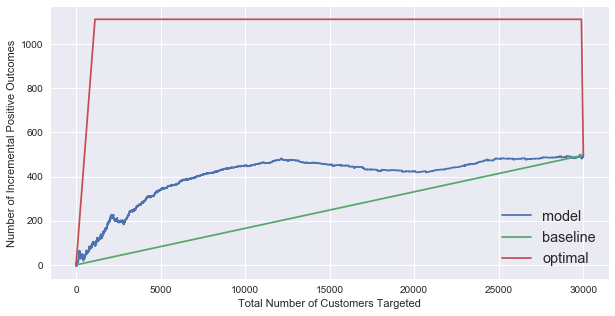

In [52]:
plt.figure(figsize=[10,5])

plt.xlabel('Total Number of Customers Targeted')
plt.ylabel('Number of Incremental Positive Outcomes')

plt.plot(test_df['qini_score'], label='model')
plt.plot(baseline, label='baseline')
plt.plot(optimal, label='optimal')
plt.legend(loc='lower right', fontsize='x-large');

### Graph Interpretation
From the graph above, we can see that almost all of the increase in positive responses among the treatment group is achieved at around the 50% treatment mark.

Thus, theoretically we could achieve the same uplift among our customer population when targeting only 50% of this group versus targeting the entire population.

### Repeat the Qini calculation to Establish Confidence in Evaluation Metric
As a final step in this project, I follow the author's lead and rerun the Qini calculation on 30 randomized train/test splits, which generates a sample distribution of Qini ratios we can then use to establish a confidence interval.

The code below is the same as above, just grouped together into a for loop

In [ ]:
qini_values = []

for _ in range(30):
    data = data.sample(frac=1).reset_index(drop=True)
    
    train_df = data.iloc[:split_index].copy(deep=True)
    test_df  = data.iloc[split_index:].copy(deep=True)
    
    model_treat = lm.LogisticRegression()
    model_treat.fit(train_df[train_df['treatment'] == 1].iloc[:,:12], train_df[train_df['treatment'] == 1]['visit']);

    model_cntrl = lm.LogisticRegression()
    model_cntrl.fit(train_df[train_df['treatment'] == 0].iloc[:,:12], train_df[train_df['treatment'] == 0]['visit']);

    test_df['uplift'] = test_df.apply(calc_uplift, axis=1)
    test_df.sort_values('uplift', ascending=False, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    
    test_df['tot_num_pos_treat'] = test_df.apply(calc_tot_num_pos_treat, axis=1)
    test_df['tot_num_pos_cntrl'] = test_df.apply(calc_tot_num_pos_cntrl, axis=1)
    test_df['tot_num_treat'] = test_df.apply(calc_tot_num_treat, axis=1)
    test_df['tot_num_cntrl'] = test_df.apply(calc_tot_num_cntrl, axis=1)
    
    test_df['qini_score'] = test_df.apply(assign_qini_score, axis=1)
    
    TOT_NUM_POS_TREAT = test_df['tot_num_pos_treat'].values[-1]
    TOT_NUM_POS_CNTRL = test_df['tot_num_pos_cntrl'].values[-1]
    TOT_NUM_TREAT = test_df['tot_num_treat'].values[-1]
    TOT_NUM_CNTRL = test_df['tot_num_cntrl'].values[-1]
    
    qini_optimal = (TOT_NUM_POS_TREAT**2 / 2) + \
                    TOT_NUM_POS_TREAT * (len(test_df) - TOT_NUM_POS_TREAT - TOT_NUM_POS_CNTRL) + \
                   (TOT_NUM_POS_CNTRL**2 / 2) - \
                   (TOT_NUM_POS_TREAT - (TOT_NUM_TREAT*(TOT_NUM_POS_CNTRL / TOT_NUM_CNTRL))) * len(test_df) / 2
    
    qini_model = test_df['qini_score'].cumsum().values[-1] - (TOT_NUM_POS_TREAT - (TOT_NUM_TREAT*(TOT_NUM_POS_CNTRL / TOT_NUM_CNTRL))) * len(test_df) / 2
    
    qini_values.append(qini_model / qini_optimal)

In [68]:
# pretty print our Qini sample
for i in range(6):
    print(['{0:.6f}'.format(val) for val in qini_values][i:i+5])

['0.155579', '0.188347', '0.149670', '0.157031', '0.197284']
['0.188347', '0.149670', '0.157031', '0.197284', '0.198163']
['0.149670', '0.157031', '0.197284', '0.198163', '0.173274']
['0.157031', '0.197284', '0.198163', '0.173274', '0.233442']
['0.197284', '0.198163', '0.173274', '0.233442', '0.203615']
['0.198163', '0.173274', '0.233442', '0.203615', '0.144581']


#### Confidence Interval for Qini ratios
Our confidence interval range is calculated as follows:
$$CI=\Bigl(\bar{x}-t^*{s \over \sqrt{n}}, \bar{x}+t^*{s \over \sqrt{n}}\Bigr)$$

where $\bar{x}$ is sample mean, $t^*$ is critical t-score, $s$ is sample standard deviation, and $n$ is number of observations.

In our case, $t^*$ will be based on 29 degrees of freedom and a confidence level of 10%.

In [53]:
# critical t-score for 29 degrees of freedom & confidence level of 10%
t_score = 1.699

In [55]:
# sample standard deviation
std = np.std(qini_values)
# sqrt of number of observations
sqrt_n = np.sqrt(len(qini_values))

In [56]:
# confidence interval +/-
CI_range = t_score * (std / sqrt_n)
CI_range

0.007698697033717326

In [59]:
# confidence interval
print(np.mean(qini_values) + CI_range, np.mean(qini_values) - CI_range)

0.19882567345224791 0.18342827938481324


# Conclusion:
Uplift modeling is an important concept when looking to increase business performance through targeted advertising, while simultaneously trying to spend as little as possible. The difficult question, of course, is who should we target with an advertising campaign, and who should we avoid?

By conducting an experiment with random assignment to treatment and control groups, we're able to establish causality with our advertising campaign. Comparing the response rates of the treatment and control groups gives us some idea of the effectiveness of our advertising campaign, however it's possible to go one step further and model the uplift of individual customers, so that know the type of customer to target in the future, and who should be avoided.

The Two-Model Method is a basic approach that lets us calculate this uplift on an individual basis, while the Qini provides a nice evaluation metric on which to judge the classification performance of our model. 

### Next Steps:
- rerun evaluation using *conversion* target, rather than *visit*
- explore different classification algorithms (the literature notes unique approaches to uplift modeling using tree-based methods as well as SVM)
- explore different uplift modeling methods beside the Two-Model Method. The authors themselves use Revert Label, which is not explored here but would be a relatively easy extension of the uplift modeling framework. 
- explore different evaluation metrics. For example, [this project](https://medium.com/datadriveninvestor/simple-machine-learning-techniques-to-improve-your-marketing-strategy-demystifying-uplift-models-dc4fb3f927a2) looked at Starbucks purchase data and used Incremental Response Rate and Net Incremental Revenue to evaluate the uplift models
- Create uplift models for different datasets, besides CRITEO. Could use the Starbucks dataset mentioned above, or the [Hillstrom dataset](https://blog.minethatdata.com/2008/05/best-answer-e-mail-analytics-challenge.html) referenced by the CRITEO authors 